In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *
from lifelines import KaplanMeierFitter, CoxPHFitter
import math

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


In [2]:
def missing_impute(y, missing_to_num=-1):
    y_outcome = copy.deepcopy(y)
    event_indicator = (y_outcome>0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_outcome[mask] = missing_to_num
    return y_outcome

def long_to_surv(y):
    num_individuals, num_time_points = y.shape
    times = []
    events = []

    for i in range(num_individuals):
        individual = y[i].tolist()
        try:
            # Find the index of the first event (1)
            event_time = individual.index(1) + 1  # +1 if time starts at 1
            event = 1
        except ValueError:
            # If no event occurred, censor at the last time point
            event_time = num_time_points
            event = 0
        
        times.append(event_time)
        events.append(event)

    df = pd.DataFrame({
        'time': times,
        'event': events,
    })
    return df
def plot_survival_time_distribution(df_ground_truth, df_estimate, x_value):
    """
    Plots the distribution of survival times for Ground Truth and FR Estimate.

    Parameters:
    - df_ground_truth: DataFrame containing 'time' for Ground Truth.
    - df_estimate: DataFrame containing 'time' for FR Estimate.
    - x_value: The value of x (0 or 1) being plotted.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot Ground Truth Distribution
    sns.kdeplot(data=df_ground_truth, x='time', fill=True, color='blue', label='Ground Truth', alpha=0.5)
    
    # Plot FR Estimate Distribution
    sns.kdeplot(data=df_estimate, x='time', fill=True, color='green', label='FR Estimate', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Survival Time Distribution for x={x_value}')
    plt.xlabel('Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()


## Setting 1

In [12]:
s,x,z,y = generate_data_survivl(n=8000,T=10, random_seed=42, C_coeff=0.2)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=800, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.5629,	loss_y 1.5599, 1.5771, 0.0342,	loss_eta 3.0029, 3.1038, 0.2018


In [17]:

# torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.2*C  # mean parameter
mu_x1 = 0.8+0.2*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

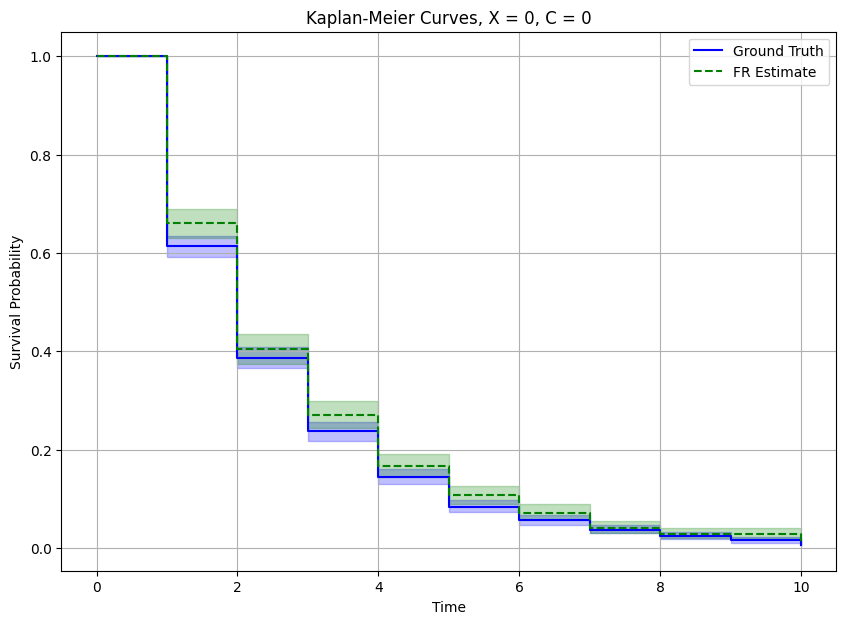

In [18]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

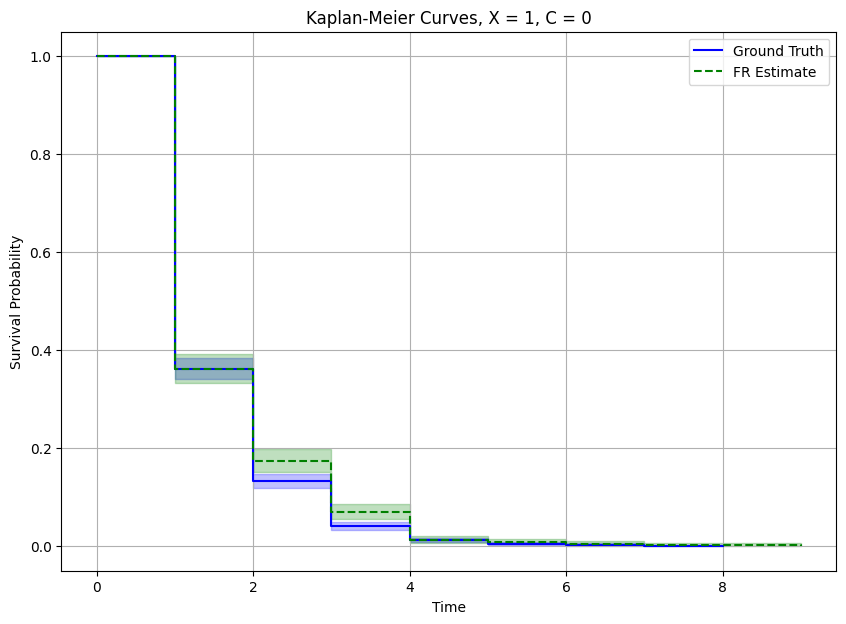

In [19]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

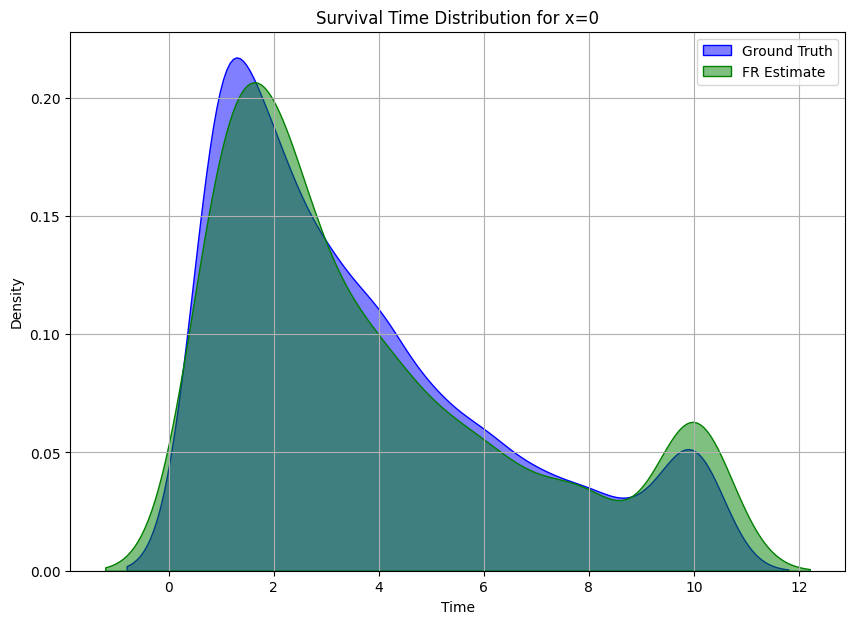

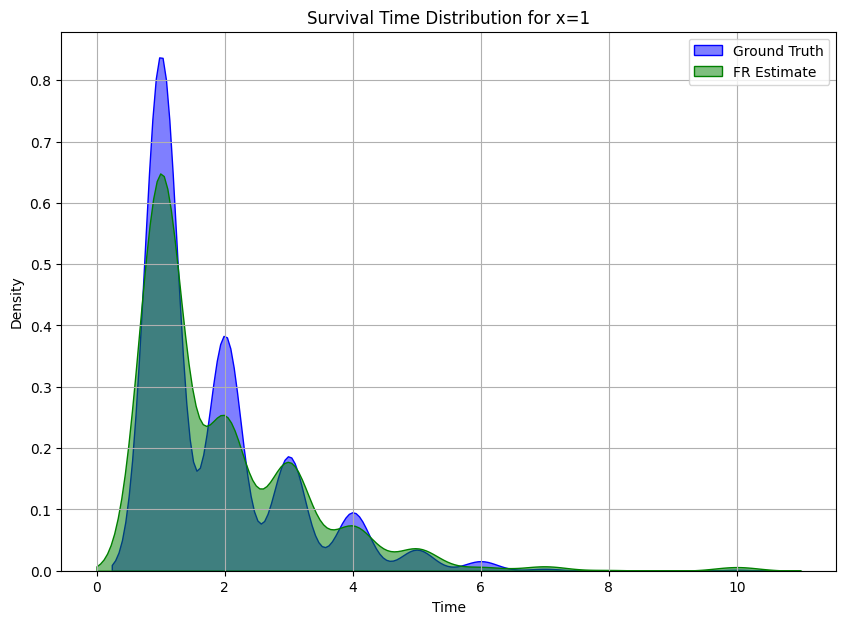

In [16]:
# Distribution for x=0
plot_survival_time_distribution(df_ground_truth=df_binary_x0,
                                df_estimate=df_x0,
                                x_value=0)

# Distribution for x=1
plot_survival_time_distribution(df_ground_truth=df_binary_x1,
                                df_estimate=df_x1,
                                x_value=1)


# Setting 2

In [4]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.5)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.5733,	loss_y 1.5816, 1.5958, 0.0283,	loss_eta 2.9917, 3.1073, 0.2312
Epoch 1000: loss 2.9207,	loss_y 0.7457, 1.3522, 1.2131,	loss_eta 2.1750, 4.3491, 4.3480
Epoch 2000: loss 2.8082,	loss_y 0.6258, 1.1875, 1.1235,	loss_eta 2.1825, 4.3481, 4.3312
Epoch 3000: loss 2.7590,	loss_y 0.5836, 1.1156, 1.0640,	loss_eta 2.1754, 4.3432, 4.3355
Epoch 4000: loss 2.7427,	loss_y 0.5573, 1.0788, 1.0430,	loss_eta 2.1854, 4.3350, 4.2991


In [19]:

torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 1+0.2*C  # mean parameter
mu_x1 = 0.9+0.2*C
phi=1

n_samples = 1000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

In [15]:
continuous_survival_times[0]

0.5282483

In [13]:
binary_data

array([[ 1, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 0,  0,  1, ..., -1, -1, -1]])

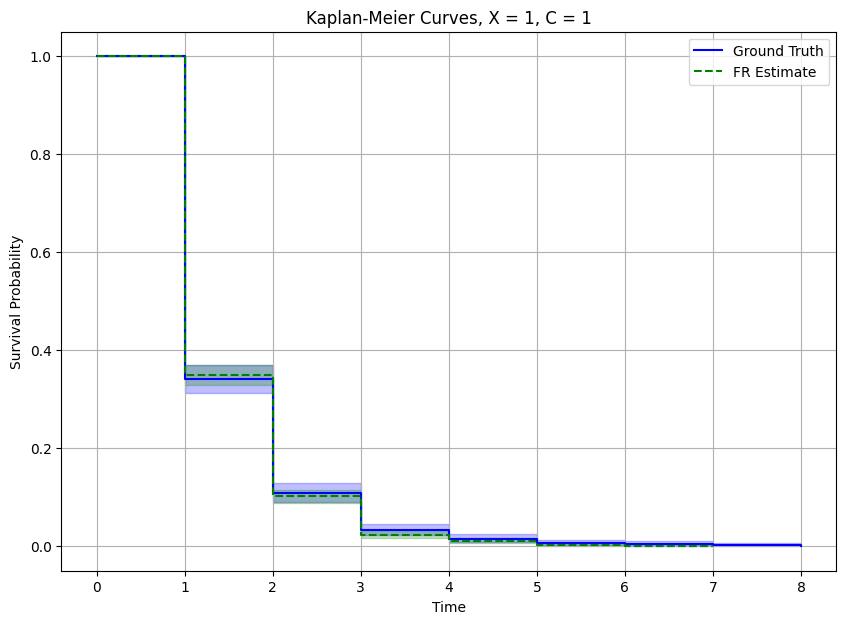

In [20]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

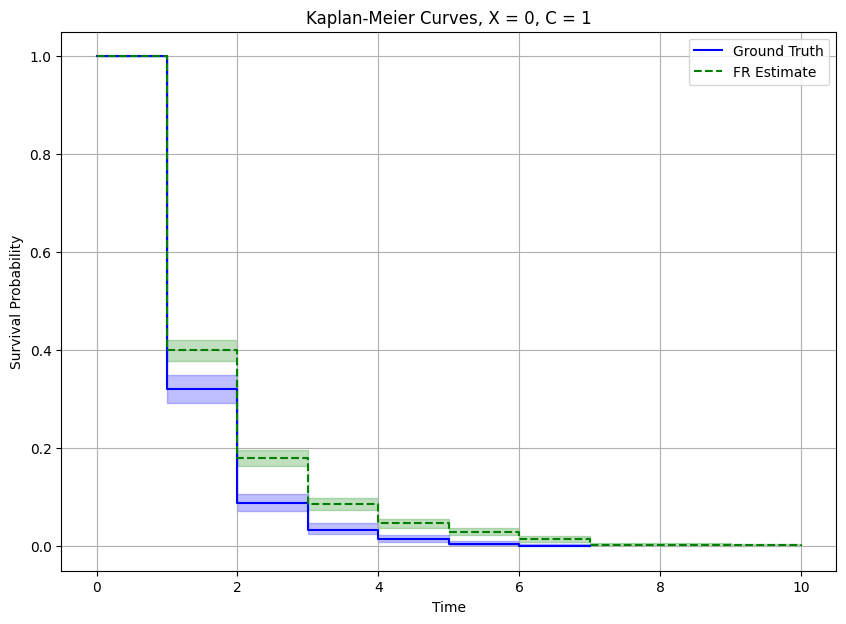

In [21]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 3

In [3]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.5)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.5696,	loss_y 1.5676, 1.5819, 0.0286,	loss_eta 3.0021, 3.1134, 0.2227
Epoch 1000: loss 2.9074,	loss_y 0.7225, 1.3283, 1.2115,	loss_eta 2.1848, 4.3572, 4.3447
Epoch 2000: loss 2.7822,	loss_y 0.5931, 1.1389, 1.0916,	loss_eta 2.1891, 4.3558, 4.3334
Epoch 3000: loss 2.7241,	loss_y 0.5284, 1.0256, 0.9946,	loss_eta 2.1958, 4.3644, 4.3372
Epoch 4000: loss 2.6907,	loss_y 0.5024, 0.9796, 0.9543,	loss_eta 2.1882, 4.3683, 4.3600


In [6]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.6911,	loss_y 0.5015, 0.9832, 0.9633,	loss_eta 2.1896, 4.3733, 4.3676
Epoch 1000: loss 2.6665,	loss_y 0.4874, 0.9588, 0.9429,	loss_eta 2.1791, 4.3519, 4.3455
Epoch 2000: loss 2.6605,	loss_y 0.4757, 0.9297, 0.9080,	loss_eta 2.1848, 4.3504, 4.3312
Epoch 3000: loss 2.6344,	loss_y 0.4610, 0.9062, 0.8905,	loss_eta 2.1734, 4.3471, 4.3474
Epoch 4000: loss 2.6532,	loss_y 0.4515, 0.8848, 0.8666,	loss_eta 2.2017, 4.3737, 4.3439


In [10]:

torch.manual_seed(42)
C=0

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 1000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

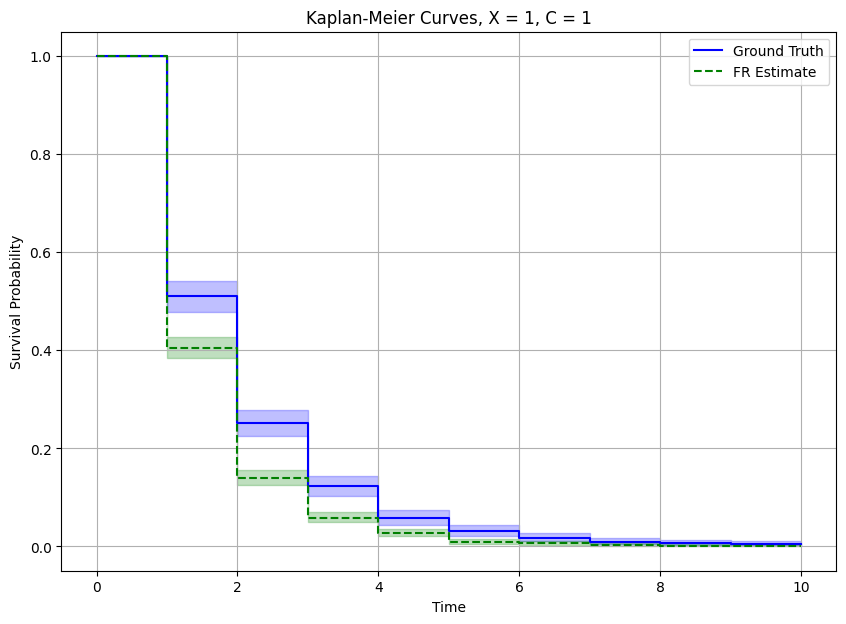

In [11]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

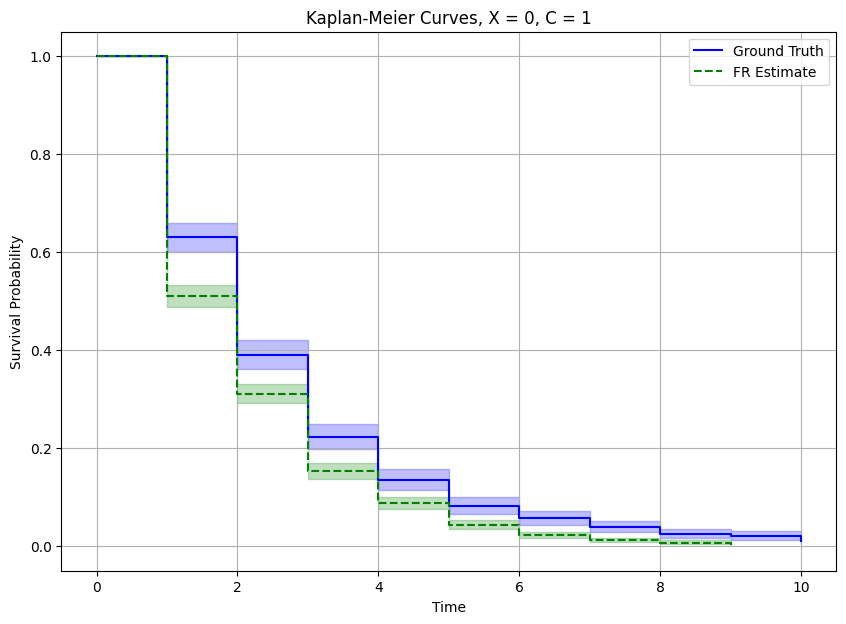

In [12]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()